# Student Name: Zhongyue Xing

## Problem 1 (10 points)

In this problem, we consider the optimal selection of a treatment. Suppose that there are 5 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4,5\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.1$, $p_2=0.3$,  $p_3=0.5$, $p_4=0.7$, $p_5=0.9$, which are not known to the doctor. This is the 5-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Optimistic Initial Values algorithm for the problem of selecting the best treatment and report the following graphs:   
(a) Run the algorithm for $t=1,2,3,\ldots,200$ and plot $R_t$'s v.s. $t$ for one simulation.   
(b) Run the trajectory in (a) for 100 epochs; and for each time step $t$ plot the average of $R_t$'s from the epochs at time particular time (please do not average all returns over time - we want to see how the learning progresses over time).   
(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=5$) was selected by the doctor. 

<u>Important</u>: In case you are using the Bandit algorithm from Chapter 2 of "Reinforcement Learning" by Sutton and Barto, which was developed for continuous outcome, please explain why the algorithm is applicable here. **Hint**: notice that the estimate of $p_a$ is the sample proportion of recovered patients out of the total number who were treated according to $a$, i.e. the simple average of all associated rewards $R_t$ does estimate $p_a$.

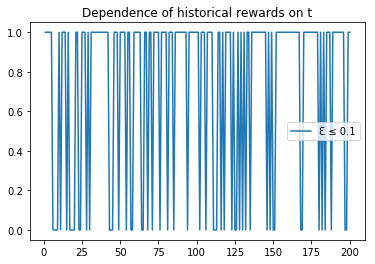

In [8]:
import numpy as np
import random
from collections import defaultdict
from matplotlib import pyplot as plt 


class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,6))

    def get_reward(self, action):
        assert action in self.admissible_actions()
        self.time += 1
        p_action = (action*2 - 1)/10
        return np.random.choice([0, 1], p = [1-p_action, p_action])

class Agent:
    def __init__(self, epsilon = 0.5):
        self.epsilon = epsilon
        self.current_reward = 0.0
        self.current_action = None
        # Latest action:reward_estimate pairs:
        self.Qk_dict = defaultdict(lambda:float("inf"))
        # Latest action:reward pairs:
        self.Rk_dict = defaultdict(float)
        # action:k pairs where k is the number of times the action was executed
        self.k_dict = defaultdict(int)

    def estimate_reward(self, action):
        if self.k_dict[action]:
            k = self.k_dict[action]
            Qk = self.Qk_dict[action]
            Rk = self.Rk_dict[action]
            # Return Q_(k+1) by incremental update rule explained in textbook chapter 2.3
            return Qk + (Rk - Qk)/k

        else:
            # 0 reward estimate for unexecuted actions means its Q_2 = R_1
            return 0

    def divide_greedy_actions(self, action_reward_est_dict):
        greedy_actions = []
        non_greedy_actions = []
        best_Q = -float('inf')
        for action, current_Q in action_reward_est_dict.items():
            if current_Q > best_Q:
                for previously_greedy_action in greedy_actions:
                    non_greedy_actions.append(previously_greedy_action)
                greedy_actions = [action]
                best_Q = current_Q
            elif current_Q == best_Q:
                greedy_actions.append(action)
            else:
                non_greedy_actions.append(action)

        return greedy_actions, non_greedy_actions

    def step(self, env):
        
        all_actions = env.admissible_actions()
        all_rewards = {}
        
        for action in all_actions:
            reward = self.estimate_reward(action)
            all_rewards[action] = reward
        
        # Estimate reward for all possible actions
        action_reward_est_dict = {
            action:self.estimate_reward(action) for action in env.admissible_actions()
        }
        # Divide greedy and non-greedy actions
        greedy_actions, non_greedy_actions = self.divide_greedy_actions(action_reward_est_dict)

        # choose greediness using epsilon, then selection an action
        if non_greedy_actions:
            selected_action = random.choice(
                np.random.choice(
                    [greedy_actions, non_greedy_actions],
                    p = [1 - self.epsilon, self.epsilon]
                )
            )
        else: # If no non-greedy options exist, all actions are greedy
            selected_action = random.choice(greedy_actions)

        # update new action
        self.current_action = selected_action
        # update new reward
        reward = env.get_reward(selected_action)
        self.current_reward = reward
        # update k, R_k and Q_k
        self.Qk_dict[selected_action] = action_reward_est_dict[selected_action]
        self.Rk_dict[selected_action] = self.current_reward
        self.k_dict[selected_action] += 1
        # reduce epsilon, gradually stop exploration
        if env.time > len(all_actions)**2:
            self.epsilon = self.epsilon/2

def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


T = 200
plt.plot(range(1,T+1),rewards_hist(T),label='Ɛ ≤ 0.1')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

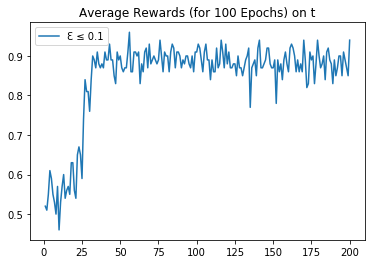

In [2]:
def average_rewards_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            rewards[ep][t] = agent.current_reward
            t += 1
    return np.mean(rewards, axis=0) # average over column

from matplotlib import pyplot as plt
import numpy as np   
T = 200
eps = 100
plt.plot(range(1,T+1), average_rewards_hist(T, eps), label= 'Ɛ ≤ 0.1')
plt.title('Average Rewards (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

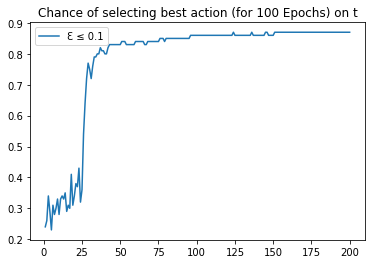

In [10]:
def percentage_best_action(best_action, T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            if agent.current_action == best_action:
                rewards[ep][t] = True
            else:
                rewards[ep][t] = False
            t += 1
    return np.mean(rewards, axis=0) # average over column
 
T = 200
eps = 100
plt.plot(range(1,T+1), percentage_best_action(5, T, eps), label= 'Ɛ ≤ 0.1')
plt.title('Chance of selecting best action (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

## Problem 2 (10 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an improtant step as it allows one to accuratly estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "Hight"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>

Using this information, please find the optimal policy for the decision making via the Policy <u>Iteration</u> (algorithm on p. 80 of "Reinforcement Learning" by Sutton and Barto).  

In [13]:
import numpy as np
from collections import defaultdict


class Environment:
    """
    Hospital patient flow model can take state [0, 1, 2]
    These state corresponds to states based on the number of patients
    ["low", "medium", "high"]
    
    """
    def __init__(self, state = 0):
        self.time = 1
        self.state = state
        self.transition = [
            [[0.8, 0.2, 0],[0.25, 0.7, 0.05],[0.01, 0.25, 0.74]],
            [[None, None, None],[0.35, 0.61, 0.04],[0.02, 0.34, 0.64]],
            [[None, None, None],[None, None, None],[0.03, 0.43, 0.54]]
            ]

    def admissible_actions(self, state):
        return list(range(state + 1))
    
    def all_states(self):
        return [0, 1, 2]
    
    def expect_reward(self, action, new_state):
        assert(new_state in self.all_states())
        return (new_state == 0)*4.95 + (new_state == 1)*15.05 - (new_state == 2)*1.45 - action



def policy_iteration(env = Environment(), gamma = 0.9):
    def choose_action(env, pi, state):
        return np.random.choice(env.admissible_actions(state), p = pi[state])

    def policy_eval(env, pi, V, gamma, theta = 0.0000000000000000000001):
        """
        Input policy a pi function and information of the environment
        to estimate its expected value under pi. Return a default dictionary
        of state:expected_values

        """

        while True:
            delta = 0
            for state in env.all_states():
                v = V[state]
                sumV = 0

                for new_state in env.all_states():

                    action = choose_action(env, pi, state)
                    transition_prob = env.transition[action][state][new_state]
                    reward = env.expect_reward(action, new_state)

                    sumV += transition_prob *(reward + gamma*V[new_state])

                V[state] = sumV

                delta = max(delta, abs(v - V[state]))

            if delta < theta:
                break

        return V
    
    def best_action(env, state, V, gamma):
        """
        Find argmax_a q_pi(s, a)
        
        """
        best_action_val = -float('inf')
        best_action = None
        for action in env.admissible_actions(state):
            action_eval = 0
            for new_state in env.all_states():
                transition_prob = env.transition[action][state][new_state]
                reward = env.expect_reward(action, new_state)
                action_eval += transition_prob *(reward + gamma*V[new_state])
            
            if action_eval > best_action_val:
                # breaks tie by selecting first argmax
                best_action_val = action_eval
                best_action = action

        if best_action == None:
            raise (ValueError, "evaluation score must exceed negative infinity")
        else:
            return best_action


    # Initialization
    policy = [[1], [0, 1], [0, 0, 1]]
    V = list(0 for i in range(len(env.all_states())))

    while True:
        # policy evaluation
        V = policy_eval(env, policy, V, gamma)
        policy_stable = True

        # policy improvement
        for state in env.all_states():
            old_action = choose_action(env, policy, state)
            new_action = best_action(env, state, V, gamma)
            if old_action != new_action:
                policy[state][old_action] = 0
                policy[state][new_action] = 1
                policy_stable = False
        if policy_stable:
            return policy, V


optimal_policy, V = policy_iteration()
print("optimal policy:")
print(optimal_policy)
print("optimal state value:")
print(V)

optimal policy:
[[1], [1, 0], [0, 0, 1]]
optimal state value:
[84.77918503209756, 93.15651004992954, 82.05760191671081]


## Problem 3 (5 points)
For the policy you obtained in Problem 2, namely $\pi(a|s)$ (hopefully, this is the optimal policy, in fact), please estimate the state values $v_\pi(s)$ via the Iterative Policy <u>Evaluation</u> (algorithm on p.75 of "Reinforcement Learning" by Sutton and Barto), i.e. by solving the Bellman equation for the state values $v_\pi(s)$.

Compare the estimated state values with their estimates you obtained as a result of the Policy Iteration in Problem 2. Are they same? Discuss.  

In [5]:
def policy_eval(env, pi, V, gamma = 0.9, theta = 0.0000000000000000000001):
    """
    Input policy a pi function and information of the environment
    to estimate its expected value under pi. Return a default dictionary
    of state:expected_values

    """
    def choose_action(env, pi, state):
        return np.random.choice(env.admissible_actions(state), p = pi[state])

    while True:
        delta = 0
        for state in env.all_states():
            v = V[state]
            sumV = 0

            for new_state in env.all_states():
                assert (1 in pi[state]), "policy is deterministic"
                action = choose_action(env, pi, state)
                transition_prob = env.transition[action][state][new_state]
                reward = env.expect_reward(action, new_state)
                sumV += transition_prob *(reward + gamma*V[new_state])

            V[state] = sumV

            delta = max(delta, abs(v - V[state]))

        if delta < theta:
            break

    return V

policy_eval(Environment(), optimal_policy, [0,0,0])

[84.77918503209756, 93.15651004992954, 82.05760191671081]

The estimated values for question 2 & 3 the same since the finalised optimal policy is evaluated by the same evaluation algorithm. (In question 2 this occured during the final iteration of the program, before policy improvement deemed the policy to be stable). Since a numerically accurate evaluation may not be neccessary for policy iteration algorithm, the two policy evaluation results can be different by setting different theta values. Specifically, theta values can be higher for Q2 to save computation time.

In [6]:
exit